In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

from parameters import *
from lib.utils import *
from lib.keras_utils import *
from lib.RandomTransform import *
from lib.OptCarlini import *
from lib.OptTransform import *

Using TensorFlow backend.


In [2]:
# Build and load trained model
model = built_mltscl()
model.load_weights(WEIGTHS_PATH)

# Load dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset_GTSRB(
    n_channel=N_CHANNEL)

y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)
y_val = keras.utils.to_categorical(y_val, NUM_LABELS)

# Read sign names
signnames = read_csv("./signnames.csv").values[:, 1]

In [3]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 32)    2432        input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 32, 32)    0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 16, 16, 32)    0           dropout_1[0][0]                  
___________________________________________________________________________________________

### Evaluate Attacks

In [4]:
SAMPLE_IMG_DIR = './traffic_sign_samples'
SAMPLE_LABEL = './traffic_sign_samples/samples_label.txt'

In [6]:
# Load sample images and labels
x_smp, x_smp_full, y_smp, masks, masks_full = load_samples(SAMPLE_IMG_DIR, SAMPLE_LABEL)

In [7]:
# Set target class to attack
tg = 10
size = 10
y_target = np.zeros((len(x_test))) + tg
y_target = keras.utils.to_categorical(y_target, NUM_LABELS)

# Filter samples
x_fil, y_fil, del_id = filter_samples(model, x_smp, y_smp, y_target=y_target)
x_fil_full = np.delete(x_smp_full, del_id, axis=0)
masks_fil = np.delete(masks, del_id, axis=0)
masks_fil_full = np.delete(masks_full, del_id, axis=0)

# Set samples to attack
ind = np.random.choice(range(len(y_fil)), size=size)
x_ben = np.copy(x_fil[ind])
x_ben_full = np.copy(x_fil_full[ind])
y_ben = np.copy(y_fil[ind])
y_tg = np.copy(y_target[ind])
masks_ben = np.copy(masks_fil[ind])
masks_ben_full = np.copy(masks_fil_full[ind])

In [6]:
# Optimization attack
x_opt = np.zeros((size,) + INPUT_SHAPE)
norm_opt = np.zeros((size,))
opt = OptCarlini(model, c=1, lr=0.01, target=True, use_bound=False, init_scl=0.1,
                 loss_op=0, var_change=True, k=5)

for i, x in enumerate(x_ben):
    x, norm = opt.optimize_search(x, y_tg[i], n_step=1000, search_step=10, prog=False)
    x_opt[i] = np.copy(x)
    norm_opt[i] = norm
    
norm_opt = np.array(norm_opt)

Finished in 161.71s
Finished in 161.97s
Finished in 162.45s
Finished in 179.18s
Finished in 181.01s
Finished in 182.90s
Finished in 177.60s
Finished in 182.69s
Finished in 185.91s
Finished in 192.66s


In [13]:
sum_norm = 0
n_suc = 0
for norm in norm_opt:
    if norm is not None:
        sum_norm += norm
        n_suc += 1
print sum_norm / n_suc

1.59478321671


In [36]:
# Optimization attack
x_opt = np.zeros((size,) + INPUT_SHAPE)
norm_opt = np.zeros((size,))
opt = OptCarlini(model, c=1, lr=0.01, target=True, use_bound=False, init_scl=0.1,
                 loss_op=0, var_change=True, k=5, use_mask=True)

for i, x in enumerate(x_ben):
    x, norm = opt.optimize(x, y_tg[i], n_step=1000, prog=False, mask=masks_ben[i])
    x_opt[i] = np.copy(x)
    norm_opt[i] = norm
    
sum_norm = 0
n_suc = 0
for norm in norm_opt:
    if norm is not None:
        sum_norm += norm
        n_suc += 1
print sum_norm / n_suc

1.8643779099


In [37]:
print norm_opt

[ 1.93199635  2.44927192  1.16068017  1.86288416  0.66149539  1.39702642
  1.09721565  3.22358394  3.534168    1.3254571 ]


In [32]:
# Optimization attack
x_opt = np.zeros((size,) + INPUT_SHAPE)
norm_opt = np.zeros((size,))
opt = OptCarlini(model, c=1, lr=0.01, target=True, use_bound=False, init_scl=0.1,
                 loss_op=0, var_change=True, k=5, use_mask=False)

for i, x in enumerate(x_ben):
    x, norm = opt.optimize(x, y_tg[i], n_step=1000, prog=False)
    x_opt[i] = np.copy(x)
    norm_opt[i] = norm
    
sum_norm = 0
n_suc = 0
for norm in norm_opt:
    if norm is not None:
        sum_norm += norm
        n_suc += 1
print sum_norm / n_suc

1.84612784982


In [33]:
print norm_opt

[ 1.70868933  2.47164607  1.22669017  1.81544006  0.61086053  1.32873011
  1.14313006  3.17862248  3.80720401  1.17026567]


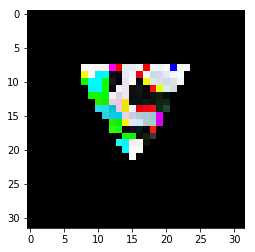

In [38]:
plt.imshow(x_opt[0] - x_ben[0])

In [35]:
x_opt[0] - x_ben[0]

array([[[  1.53982639e-03,   1.91122293e-03,  -1.10447407e-04],
        [ -2.95042992e-05,  -3.27682495e-03,  -3.55541706e-03],
        [ -6.46412373e-04,  -3.64184380e-03,  -3.34829092e-03],
        ..., 
        [ -5.29795885e-04,  -2.09802389e-03,   7.57962465e-04],
        [  4.13194299e-03,  -3.73929739e-04,   4.15906310e-03],
        [ -1.04379654e-03,  -3.68416309e-03,  -2.05016136e-03]],

       [[  1.58962607e-03,   1.02624297e-03,  -3.20279598e-03],
        [  1.63671374e-03,  -3.59898806e-03,  -3.80548835e-03],
        [ -8.00669193e-04,  -4.61328030e-03,  -3.28478217e-03],
        ..., 
        [ -3.79651785e-04,   1.95017457e-03,   9.63017344e-04],
        [  1.36211514e-03,  -4.99665737e-04,  -1.02292001e-03],
        [  2.01910734e-03,   1.56646967e-03,   1.49823725e-03]],

       [[ -3.78340483e-04,  -1.95038319e-03,  -2.29886174e-03],
        [  1.06790662e-03,  -3.68559361e-03,  -2.02676654e-03],
        [  7.00920820e-04,  -4.73755598e-03,  -1.96069479e-03],
        

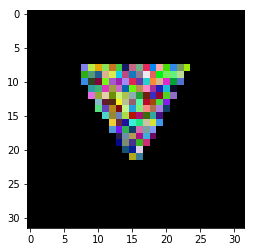

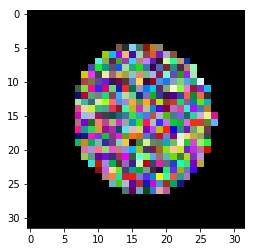

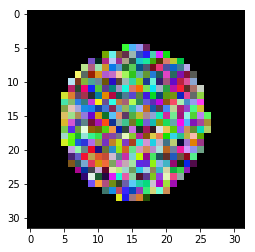

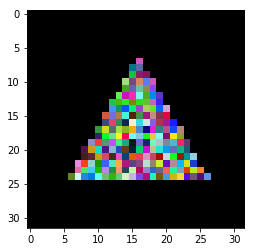

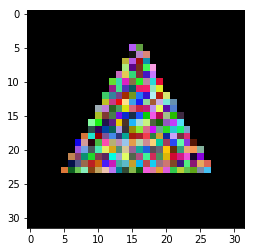

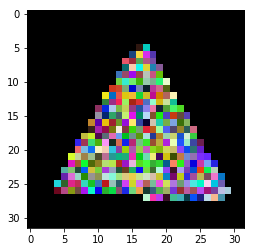

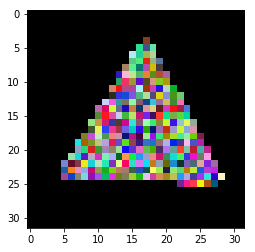

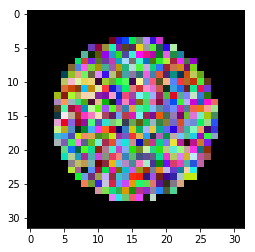

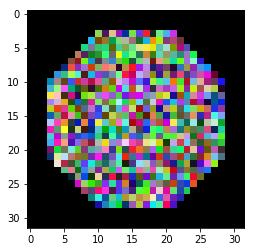

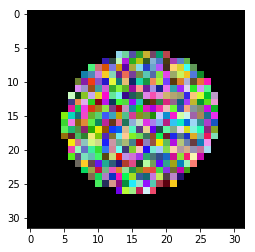

In [24]:
# FG attack
x_fg = fg(model, x_ben, y_tg, [1.6], target=True, mask=masks_ben)

In [25]:
# Iterative attack
x_it = iterative(model, x_ben, y_tg, n_step=32, step_size=0.05, target=True, mask=masks_ben)

In [32]:
# Evaluate each attack
print eval_adv(model, x_opt, y_tg, target=True)
print eval_adv(model, x_fg, y_tg, target=True)
print eval_adv(model, x_it, y_tg, target=True)

0.9
[0.20000000000000001]
0.7


In [33]:
x_fg.shape

(1, 10, 32, 32, 3)

### Model trainer

In [23]:
filepath = './weights.{epoch:02d}-{val_loss:.2f}.hdf5'
modelCheckpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                                                  save_best_only=False, save_weights_only=False, 
                                                  mode='auto', period=1)
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                                          verbose=0, mode='auto')

In [24]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epoch, verbose=1, 
          callbacks=[modelCheckpoint, earlyStop], validation_data=(x_val, y_val), 
          shuffle=True, initial_epoch=0)

Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 19s - loss: 1.4503 - acc: 0.6749 - val_loss: 0.6975 - val_acc: 0.8993
Epoch 2/100
34799/34799 [==============================] - 18s - loss: 0.4860 - acc: 0.9393 - val_loss: 0.5030 - val_acc: 0.9263
Epoch 3/100
34799/34799 [==============================] - 18s - loss: 0.3762 - acc: 0.9621 - val_loss: 0.4678 - val_acc: 0.9202
Epoch 4/100
34799/34799 [==============================] - 18s - loss: 0.3374 - acc: 0.9697 - val_loss: 0.4584 - val_acc: 0.9517
Epoch 5/100
34799/34799 [==============================] - 18s - loss: 0.3217 - acc: 0.9740 - val_loss: 0.3861 - val_acc: 0.9594
Epoch 6/100
34799/34799 [==============================] - 18s - loss: 0.2947 - acc: 0.9770 - val_loss: 0.3729 - val_acc: 0.9628
Epoch 7/100
34799/34799 [==============================] - 18s - loss: 0.2859 - acc: 0.9786 - val_loss: 0.3604 - val_acc: 0.9531
Epoch 8/100
34799/34799 [=======================

In [98]:
# Try attack overfitted model